In [4]:
!pip install nltk
import pandas as pd
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import pipeline
import torch
from concurrent.futures import ThreadPoolExecutor

nltk.download('punkt')
nltk.download('punkt_tab')


file_path = "/content/Cleaned Smart Email Dataset.csv"
df = pd.read_csv(file_path).sample(n=50, random_state=42) #50 mails

df['Email Content'] = df['Email Content'].astype(str)
df = df[df['Email Content'].str.split().str.len() > 10]

# Extractive summarization function
def extractive_summary(text, num_sentences=1):
    sentences = nltk.sent_tokenize(text)
    if len(sentences) <= num_sentences:
        return text


    vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
    try:
        sentence_vectors = vectorizer.fit_transform(sentences)
        ranked_sentences = sorted(((sum(vec.toarray()[0]), s) for vec, s in zip(sentence_vectors, sentences)), reverse=True)
        return ranked_sentences[0][1]
    except:
        return sentences[0]


device = 0 if torch.cuda.is_available() else -1
summarizer = pipeline("summarization", model="t5-small", device=device, truncation=True)

# Abstractive summarization with batch processing
def abstractive_summary_batch(texts):


    processed_texts = [" ".join(t.split()[:200]) for t in texts]

    try:
        summaries = summarizer(processed_texts, max_length=30, min_length=10,
                             do_sample=False, truncation=True, batch_size=4)
        return [s['summary_text'] for s in summaries]
    except Exception as e:
        print(f"Error in batch summarization: {e}")
        return texts  # Return original text if error


batch_size = 4
email_contents = df['Email Content'].tolist()

abstractive_summaries = []
for i in range(0, len(email_contents), batch_size):
    batch = email_contents[i:i+batch_size]
    abstractive_summaries.extend(abstractive_summary_batch(batch))

df['Abstractive_Summary'] = abstractive_summaries


with ThreadPoolExecutor() as executor:
    df['Extractive_Summary'] = list(executor.map(extractive_summary, email_contents))
df.to_csv("Summarized_Smart_Email_Dataset.csv", index=False)
print("Summarization completed with optimizations!")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
Device set to use cpu


Summarization completed with optimizations!


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


✅ Successfully loaded 44 summarized emails

📊 Calculating ROUGE scores...

🔍 ROUGE Scores (0-1 scale, higher is better):


,rouge1,rouge2,rougeL
Extractive,0.490347,0.487448,0.490347
Abstractive,0.114064,0.104974,0.111525


<ipython-input-8-03067bedb3fb>:70: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df['orig_len'], df['ext_len'], df['abs_len']],


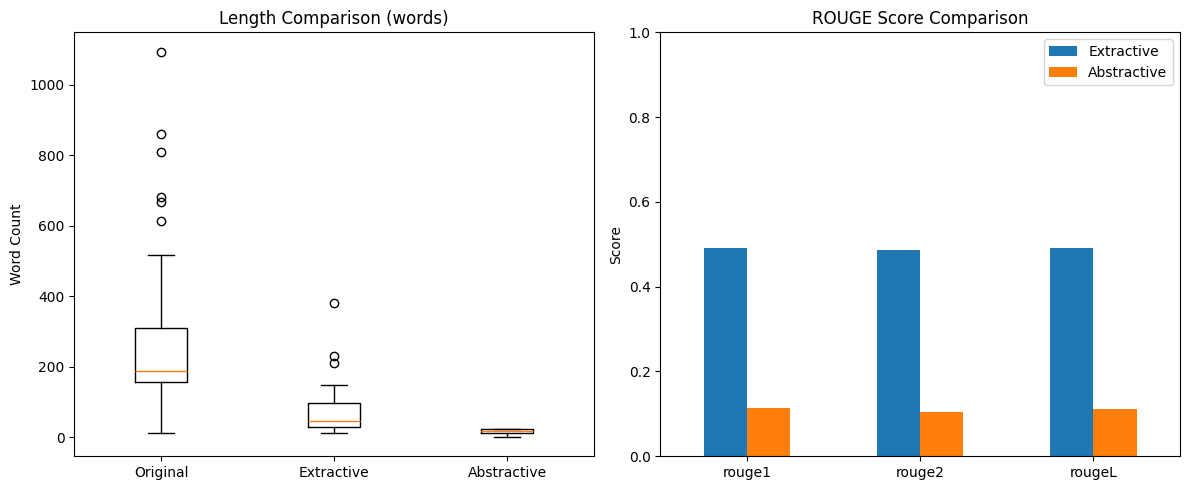


📝 Sample Results (showing 3 random emails):


In [8]:

!pip install rouge-score pandas matplotlib nltk pygments ipython

import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize
import matplotlib.pyplot as plt
from rouge_score import rouge_scorer
from IPython.display import display, HTML
import textwrap

# Download NLTK data
nltk.download('punkt')

def calculate_rouge_scores(df):
    """Calculate ROUGE scores between original and summaries"""
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    scores_ext = {'rouge1': [], 'rouge2': [], 'rougeL': []}
    scores_abs = {'rouge1': [], 'rouge2': [], 'rougeL': []}

    for _, row in df.iterrows():
        original = str(row['Email Content'])
        ext_summary = str(row['Extractive_Summary'])
        abs_summary = str(row['Abstractive_Summary'])


        ext_scores = scorer.score(original, ext_summary)
        for key in scores_ext:
            scores_ext[key].append(ext_scores[key].fmeasure)

        abs_scores = scorer.score(original, abs_summary)
        for key in scores_abs:
            scores_abs[key].append(abs_scores[key].fmeasure)

    return {
        'extractive': {k: sum(v)/len(v) for k, v in scores_ext.items()},
        'abstractive': {k: sum(v)/len(v) for k, v in scores_abs.items()}
    }

def display_summarization_results(results_path="/content/Summarized_Smart_Email_Dataset.csv", num_samples=3):
    """Display evaluation results with visualizations"""
    try:
        df = pd.read_csv(results_path)
        print(f"✅ Successfully loaded {len(df)} summarized emails")
    except FileNotFoundError:
        print(f"❌ Error: File not found at {results_path}")
        return


    print("\n📊 Calculating ROUGE scores...")
    rouge_scores = calculate_rouge_scores(df)


    print("\n🔍 ROUGE Scores (0-1 scale, higher is better):")
    rouge_df = pd.DataFrame({
        'Extractive': rouge_scores['extractive'],
        'Abstractive': rouge_scores['abstractive']
    }).T
    display(rouge_df.style.background_gradient(cmap='Blues', axis=None))


    plt.figure(figsize=(12, 5))


    plt.subplot(1, 2, 1)
    df['orig_len'] = df['Email Content'].str.split().str.len()
    df['ext_len'] = df['Extractive_Summary'].str.split().str.len()
    df['abs_len'] = df['Abstractive_Summary'].str.split().str.len()

    plt.boxplot([df['orig_len'], df['ext_len'], df['abs_len']],
                labels=['Original', 'Extractive', 'Abstractive'])
    plt.title('Length Comparison (words)')
    plt.ylabel('Word Count')

    plt.subplot(1, 2, 2)
    rouge_df.T.plot(kind='bar', ax=plt.gca())
    plt.title('ROUGE Score Comparison')
    plt.ylabel('Score')
    plt.xticks(rotation=0)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

    print(f"\n📝 Sample Results (showing {num_samples} random emails):")
    samples = df.sample(num_samples)

    for idx, row in samples.iterrows():
        html_content = f"""
        <div style="font-family: Arial; margin: 20px 0; padding: 15px; border: 1px solid #eee; border-radius: 8px; background: #f9f9f9;">
            <h3 style="color: #2c3e50; margin-top: 0;">📩 {row['Mail Subject']}</h3>

            <div style="margin-bottom: 15px;">
                <h4 style="color: #3498db; margin-bottom: 5px;">Original Content:</h4>
                <div style="background: white; padding: 10px; border-radius: 5px; max-height: 150px; overflow-y: auto;">
                    {textwrap.shorten(str(row['Email Content']), width=300, placeholder='...')}
                </div>
            </div>

            <div style="display: flex; gap: 15px;">
                <div style="flex: 1; background: #e8f5e9; padding: 10px; border-radius: 5px;">
                    <h4 style="color: #27ae60; margin-top: 0;">Extractive Summary</h4>
                    <p>{row['Extractive_Summary']}</p>
                </div>

                <div style="flex: 1; background: #ffebee; padding: 10px; border-radius: 5px;">
                    <h4 style="color: #e74c3c; margin-top: 0;">Abstractive Summary</h4>
                    <p>{row['Abstractive_Summary']}</p>
                </div>
            </div>
        </div>
        """
        display(HTML(html_content))

# Run the evaluation
display_summarization_results()